# Analysing Xenium data with scllm

## Summary

In this code, we analyze single-cell RNA sequencing data stored in an HDF5 file. We begin by downloading the dataset and loading it into an AnnData object using Scanpy. We calculate quality control metrics and visualize key features such as total transcripts and unique genes per cell. After filtering low-quality cells and genes, we normalize the data and perform dimensionality reduction using PCA and UMAP. We then cluster the cells using the Leiden algorithm and visualize the clusters spatially. Finally, we annotate the clusters with a language model and generate heatmaps to explore gene expression patterns within the annotated clusters. This workflow allows us to gain insights into the cellular composition and gene expression dynamics of the sample.

## Setup

In these lines, we use `wget` to download the Xenium dataset file named `xenium_rep1.h5ad` from a specified URL. This is our starting point for the analysis. By running this command, we ensure that we have the necessary data file saved in our current working directory, which we’ll later load into our script using Scanpy. This dataset contains single-cell RNA sequencing data that we’ll analyze to identify cell types.

In [1]:
!wget https://www.huber.embl.de/users/harald/embo/xenium_rep1.h5ad ./xenium_rep1.h5ad

--2025-03-09 07:43:45--  https://www.huber.embl.de/users/harald/embo/xenium_rep1.h5ad
Resolving www.huber.embl.de (www.huber.embl.de)... 194.94.45.72
Connecting to www.huber.embl.de (www.huber.embl.de)|194.94.45.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108640284 (104M) [application/octet-stream]
Saving to: 'xenium_rep1.h5ad'

xenium_rep1.h5ad    100%[===================>] 103.61M  1.32MB/s    in 80s     

2025-03-09 07:45:05 (1.30 MB/s) - 'xenium_rep1.h5ad' saved [108640284/108640284]

--2025-03-09 07:45:05--  http://./xenium_rep1.h5ad
Resolving . (.)... failed: nodename nor servname provided, or not known.
wget: unable to resolve host address '.'
FINISHED --2025-03-09 07:45:05--
Total wall clock time: 1m 20s
Downloaded: 1 files, 104M in 1m 20s (1.30 MB/s)


In this part of the script, we’re setting up our environment to use the OpenAI API for annotating cell clusters. First, we load the environment variables using `load_dotenv()`, which allows us to access our API key securely without hardcoding it. Then, we import necessary libraries: `scanpy` for single-cell analysis, `scllm` for leveraging the language model, and `matplotlib` and `seaborn` for plotting. 

Next, we initialize the `ChatOpenAI` model with a specified temperature and model type, which will help us generate annotations for our cell clusters later on. This setup is crucial for the subsequent steps where we analyze the Xenium dataset and identify cell types based on the clustering results.

In [42]:
# Enter your API key for ChatGPT
# import os
# os.environ["OPENAI_API_KEY"] = "Enter your API key here."
# Or alternatively save your OPENAI key in a .env file and load it via dotenv
from dotenv import load_dotenv
load_dotenv()
from langchain_openai import ChatOpenAI

import scanpy as sc
import scllm as sl
import matplotlib.pyplot as plt
import seaborn as sns

In these lines, we set up the language model we’ll use for annotating our cell clusters. The variable `openai_model` is assigned the model name "gpt-4o-mini," which is a smaller version of OpenAI's GPT-4, optimized for quicker responses. Then, we create an instance of `ChatOpenAI` with a temperature of 0.0, meaning we want deterministic outputs—no randomness in the responses. This is crucial for consistent annotations of our cell types later in the script. By using this model, we can leverage AI to help us interpret the clusters we identified in our Xenium dataset, making our analysis more insightful and efficient.

In [43]:
openai_model = "gpt-4o-mini"
llm = ChatOpenAI(temperature=0.0, model=openai_model)

## Data Preprocessing

We start by loading our Xenium dataset using `sc.read_h5ad('xenium_rep1.h5ad')`, which reads the data into an AnnData object, `adata`. This object will hold our single-cell data, including gene expression and metadata. Next, we calculate quality control metrics with `sc.pp.calculate_qc_metrics`, which helps us assess the quality of our cells by looking at total counts and unique genes. We then compute the percentage of negative DNA probe counts and decoding counts, giving us insights into potential issues in our data. After that, we visualize the distributions of total transcripts, unique transcripts, cell area, and nucleus ratio using histograms. Finally, we filter out low-quality cells and genes, normalize the data, and log-transform it to prepare for downstream analysis like PCA and clustering.

In [ ]:
adata = sc.read_h5ad('xenium_rep1.h5ad')

In this script, we start by loading our Xenium dataset and calculating quality control metrics using `sc.pp.calculate_qc_metrics`. This function helps us assess the quality of our single-cell RNA-seq data by providing statistics like the total counts and number of genes detected per cell. The `percent_top` parameter allows us to specify which percentiles of the data we want to analyze, giving us insights into the distribution of transcript counts.

In [ ]:
sc.pp.calculate_qc_metrics(adata, percent_top=(10, 20, 50, 150), inplace=True)

In this part of the code, we calculate the percentage of negative DNA probe counts and negative decoding counts in our Xenium dataset. The `cprobes` variable computes the total control probe counts divided by the total counts, multiplied by 100 to get a percentage. Similarly, `cwords` does the same for control codeword counts. 

These metrics help us assess the quality of our data by indicating how much of the total counts are attributed to negative controls. If these percentages are high, it might suggest issues with the data quality, which we need to consider before diving deeper into cell type identification. Finally, we print these values to get a quick overview of our dataset's integrity.

In [35]:
cprobes = (
    adata.obs["control_probe_counts"].sum() / adata.obs["total_counts"].sum() * 100
)
cwords = (
    adata.obs["control_codeword_counts"].sum() / adata.obs["total_counts"].sum() * 100
)
print(f"Negative DNA probe count % : {cprobes}")
print(f"Negative decoding count % : {cwords}")

Negative DNA probe count % : 0.08838749926953768
Negative decoding count % : 0.006644247962710972


In this part of the script, we’re creating a set of four histograms to visualize key metrics from our Xenium dataset. Each subplot gives us insights into different aspects of the cell data. 

First, we plot the total transcripts per cell, which helps us understand the overall expression levels. Next, we look at unique transcripts per cell to gauge the diversity of gene expression. The third plot shows the area of segmented cells, giving us a sense of cell size. Finally, we calculate and visualize the nucleus ratio, which is the proportion of the nucleus area to the total cell area, helping us assess cell morphology. 

These visualizations are crucial for identifying potential issues in our dataset and understanding the biological context of the cells we're analyzing.

<Axes: title={'center': 'Nucleus ratio'}, ylabel='Count'>

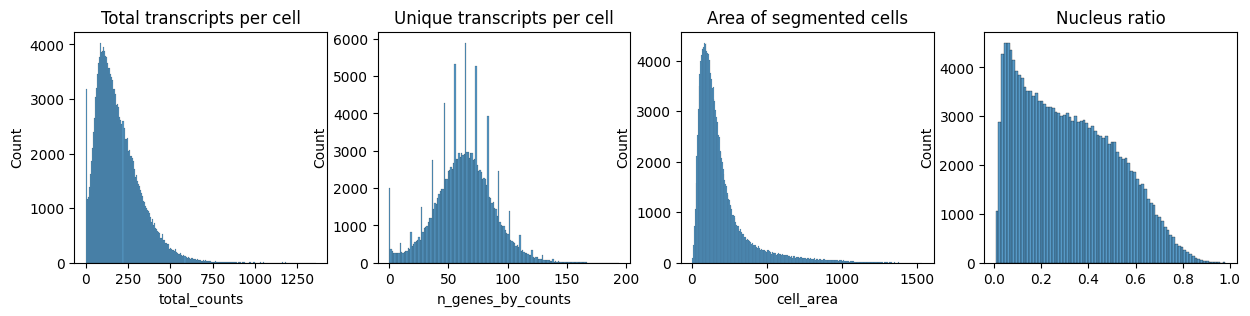

In [37]:
fig, axs = plt.subplots(1, 4, figsize=(15, 3))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    adata.obs["total_counts"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(
    adata.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
)


axs[2].set_title("Area of segmented cells")
sns.histplot(
    adata.obs["cell_area"],
    kde=False,
    ax=axs[2],
)

axs[3].set_title("Nucleus ratio")
sns.histplot(
    adata.obs["nucleus_area"] / adata.obs["cell_area"],
    kde=False,
    ax=axs[3],
)

In this part of the script, we’re filtering our dataset to clean it up a bit. The line `sc.pp.filter_cells(adata, min_counts=10)` removes any cells that have fewer than 10 total counts. This helps us get rid of low-quality or empty cells that could skew our analysis. 

Next, `sc.pp.filter_genes(adata, min_cells=5)` filters out genes that are not expressed in at least 5 cells. This step ensures that we focus on genes that are actually relevant and expressed in our dataset, which is crucial for accurate cell type identification later on. By doing this, we’re making sure our data is more robust and reliable for downstream analyses like clustering and annotation.

In [38]:
sc.pp.filter_cells(adata, min_counts=10)
sc.pp.filter_genes(adata, min_cells=5)

In this part of the script, we first create a copy of the raw counts data from `adata.X` and store it in `adata.layers["counts"]`. This is useful for later comparisons or analyses. Next, we normalize the total counts across cells with `sc.pp.normalize_total(adata, inplace=True)`, which helps to account for differences in sequencing depth. After normalization, we apply a log transformation with `sc.pp.log1p(adata)` to stabilize variance and make the data more suitable for downstream analyses.

Then, we perform PCA (Principal Component Analysis) using `sc.pp.pca(adata)` to reduce dimensionality and capture the main sources of variation in our data. Following PCA, we compute the neighborhood graph with `sc.pp.neighbors(adata)`, which is essential for clustering. Finally, we generate a UMAP (Uniform Manifold Approximation and Projection) representation with `sc.tl.umap(adata)` to visualize the data in two dimensions, and we identify clusters using the Leiden algorithm with `sc.tl.leiden(adata)`.

In [39]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

/var/folders/_4/qhxlw4x53134ffft2v5pt3nh0000gn/T/ipykernel_90780/4193936636.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


In this part of the script, we use `sc.pl.embedding(adata, basis='spatial', color='leiden')` to visualize the spatial distribution of our cell clusters identified by the Leiden algorithm. The `adata` object contains our single-cell data, and by specifying `basis='spatial'`, we're telling the function to plot the cells based on their spatial coordinates. The `color='leiden'` argument colors the cells according to their assigned cluster labels from the Leiden clustering. This helps us see how different cell types are organized in the tissue, giving us insights into their spatial relationships. It's a crucial step for understanding the biological context of our data.

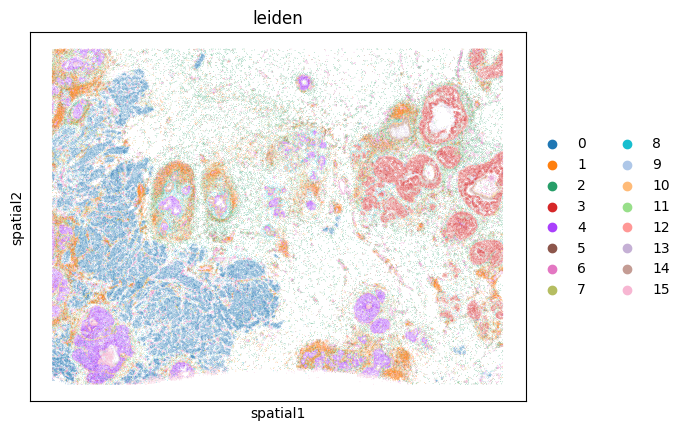

In [41]:
sc.pl.embedding(adata, basis='spatial', color='leiden')

In this part of the script, we’re using the `sl.tl.annotate_cluster` function to label the clusters we identified earlier with the Leiden algorithm. We specify `cluster_key='leiden'` to tell the function which clustering results to use. The `llm=llm` argument passes our language model (ChatGPT) to help generate meaningful annotations for each cluster. By setting `num_samples=10`, we’re asking the model to provide 10 different annotation suggestions for each cluster. This step is crucial because it helps us interpret the biological significance of the clusters we’ve identified in our Xenium dataset, making it easier to understand the different cell types present.

In [48]:
sl.tl.annotate_cluster(
    adata, 
    cluster_key='leiden',
    llm=llm,
    num_samples=10
)

/Users/harald/Documents/opt/scllm/src/scllm/tl/cluster_annotation.py:40: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  flattened=lambda df: df["union"].apply(


In this part of the script, we use `sc.pl.embedding(adata, basis='spatial', color='cluster_annotation')` to visualize the spatial distribution of our identified cell types. After processing the Xenium dataset, we performed clustering using the Leiden algorithm, which grouped similar cells together. The `cluster_annotation` contains the labels for these clusters, indicating the cell types we’ve annotated using the language model. By plotting this on a spatial embedding, we can see how different cell types are arranged in the tissue, giving us insights into their spatial relationships. This visualization helps us understand the biological context of our data and the organization of different cell types within the sample.

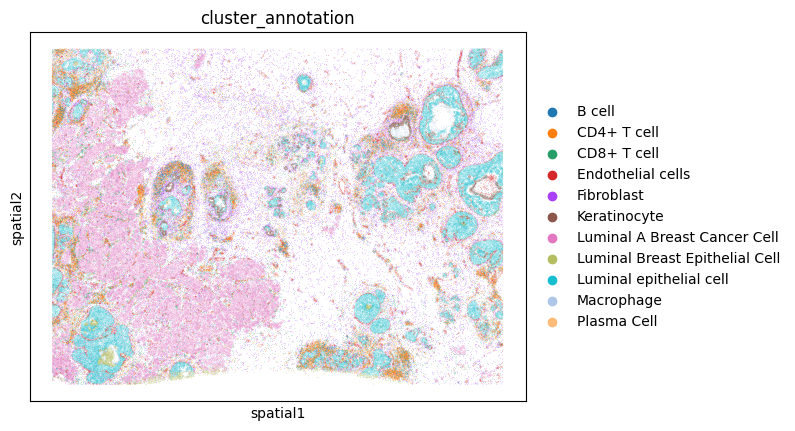

In [49]:
sc.pl.embedding(adata, basis='spatial', color='cluster_annotation')

In this part of the script, we’re generating a heatmap to visualize the expression of genes across different cell clusters that we annotated earlier. The `sc.pl.heatmap` function takes our `adata` object and groups the data by `cluster_annotation`, which we got from the previous clustering step. The `var_names` parameter specifies which genes to display, pulling them from `adata.uns['cluster_annotation']['var_names']`. This heatmap helps us quickly see how different genes are expressed in each cluster, making it easier to identify distinct cell types based on their gene expression profiles. It’s a crucial step for interpreting our clustering results and understanding the biological significance of the identified clusters.

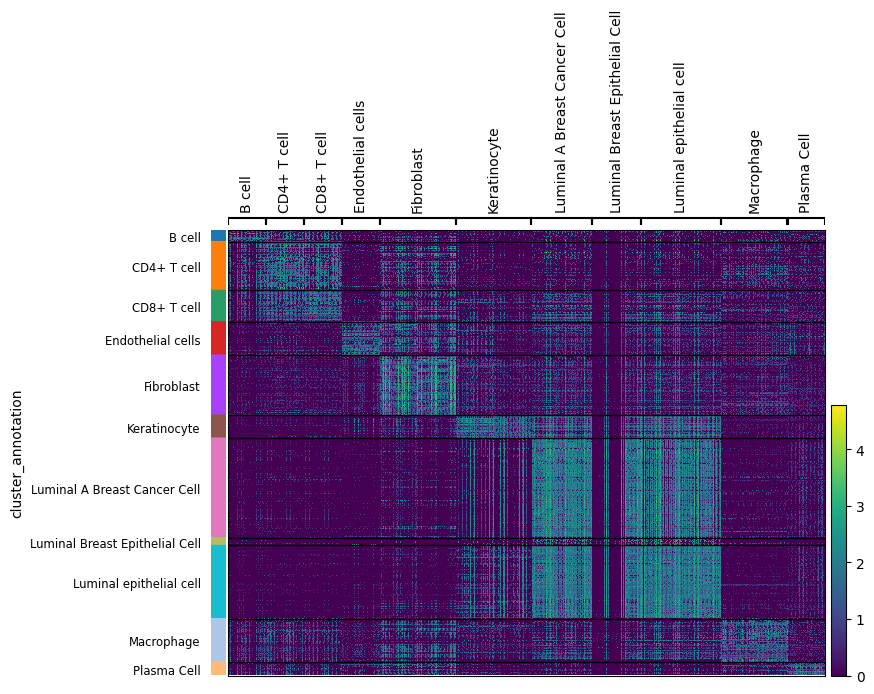

In [51]:
sc.pl.heatmap(adata, groupby='cluster_annotation', var_names=adata.uns['cluster_annotation']['var_names'])